In [1]:
import os
import csv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
# nltk.download('punkt')
# nltk.download('stopwords')
# nltk.download('wordnet')
import csv
import re
import pickle
import time
from tqdm import tqdm
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


In [3]:
SEED = 1234

np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)

torch.backends.cudnn.deterministic = True

In [4]:
data_path = "../Dataset/Toxic_comments/train.csv"
df = pd.read_csv(data_path)
df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [5]:
LABEL_COLUMNS = df.columns.tolist()[2:]
df['good'] = 1
df.loc[df[LABEL_COLUMNS].sum(axis=1) != 0, 'good'] = 0

In [6]:
train_df, test_df = train_test_split(df, test_size = 0.2)
train_df, val_df = train_test_split(train_df, test_size = 0.05)

<Axes: >

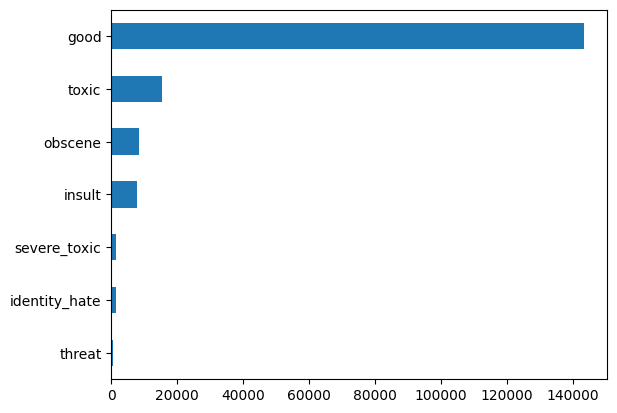

In [7]:
LABEL_COLUMNS = df.columns.tolist()[2:]
df[LABEL_COLUMNS].sum().sort_values().plot(kind="barh")

<Axes: >

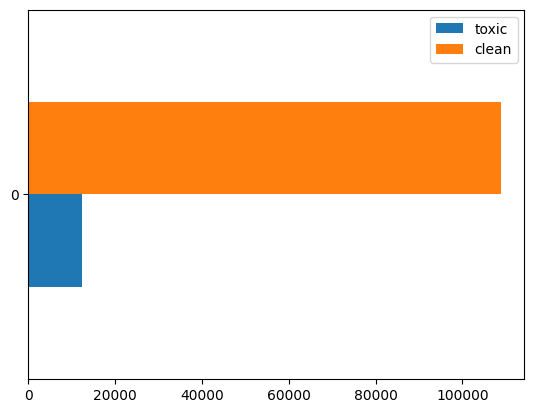

In [8]:
train_toxic = train_df[train_df['good'] == 0]
train_clean = train_df[train_df['good'] == 1]

pd.DataFrame(dict(toxic=[len(train_toxic)], clean=[len(train_clean)])).plot(kind='barh')

In [9]:
train_df = pd.concat([train_toxic, train_clean.sample(15_000)])

<Axes: >

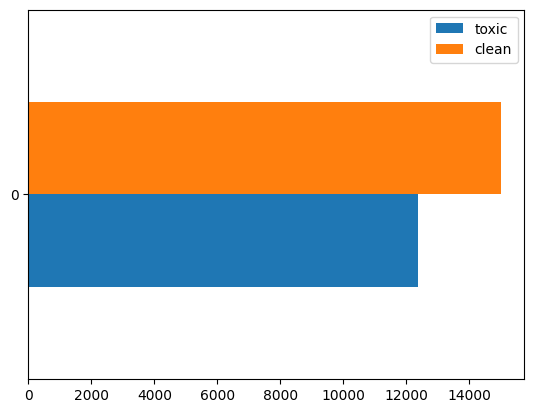

In [10]:
train_toxic = train_df[train_df['good'] == 0]
train_clean = train_df[train_df['good'] == 1]

pd.DataFrame(dict(toxic=[len(train_toxic)], clean=[len(train_clean)])).plot(kind='barh')

In [11]:
print(train_df.shape, val_df.shape, test_df.shape)

(27384, 9) (6383, 9) (31915, 9)


In [12]:
def data_preprocessing(sentences):

    tokenized_sentences = []
    for sentence in tqdm(sentences, desc = 'Tokenize'):
        sentence = sentence.lower()
        cleanr = re.compile('<.*?>')
        sentence = re.sub(cleanr, ' ', sentence)

        sentence = re.sub(r'[?|!|\'|"|#]',r'',sentence)
        sentence = re.sub(r'[.|,|)|(|\|/]',r' ',sentence)
        sentence = sentence.strip()
        sentence = sentence.replace("\n"," ")
        sentence = re.sub(r'[^A-Za-z ]', '', sentence)
        sentence = re.sub('\s+', ' ', sentence)

        tokenized_sentences.append(nltk.word_tokenize(sentence))

    stop_words = set(stopwords.words('english'))

    removed_stop_words = []
    for sentence in tqdm(tokenized_sentences, desc = 'Stop_word_removal'):
        curr_sentence = []
        for token in sentence:
            if not token in stop_words:
                curr_sentence.append(token)
        
        removed_stop_words.append(curr_sentence)

    lemmatizer = WordNetLemmatizer()

    lemmatized_sentence = []
    for sentence in tqdm(removed_stop_words, desc = 'Lemmatization'):
        curr_sentence = []
        for token in sentence:
            curr_sentence.append(lemmatizer.lemmatize(token))

        lemmatized_sentence.append(curr_sentence)

    return lemmatized_sentence

In [13]:
def vocab_builder(sentences):
    # Word dictionary
    word_vocab = {}
    unique_id = 1
    for sentence in sentences:
        for word in sentence:
            if word not in word_vocab:
                word_vocab[word] = unique_id
                unique_id += 1

    word_vocab['<PAD>'] = 0
    word_vocab['<OOV>'] = unique_id

    return word_vocab

In [14]:
def text_to_sequence(sentences, word_vocab):

    text_sequece = []
    for sentence in sentences:
        curr_sequence = []
        for word in sentence:
            if word in word_vocab:
                curr_sequence.append(word_vocab[word])
            else:
                curr_sequence.append(word_vocab['<OOV>'])
        text_sequece.append(curr_sequence)

    return text_sequece

def pad_sequences(seq, maxlen):
    padded_seq = []
    if len(seq) < maxlen:
        padding_seq = [0] * (maxlen - len(seq))
        padded_seq = padding_seq + seq
    else:
        padded_seq = seq
        
    return padded_seq


def padding(sequence, max_length):
    new_sequence = []
    for i in range(len(sequence)):
        if len(sequence[i]) <= max_length:
            new_sequence.append(sequence[i])
        else:
            new_sequence.append(sequence[i][:max_length])
            

    sequence = new_sequence

    X = []
    for seq in tqdm(sequence, desc = 'Padding'):
        X.append(pad_sequences(seq, maxlen = max_length))

    return X

In [15]:
max_length = 200

In [16]:
# Train data
train_sentences = train_df['comment_text'].values
cols = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate', 'good']
train_labels = train_df[cols].values

train_sentences = data_preprocessing(train_sentences)
word_vocab = vocab_builder(train_sentences)
vocab_size = len(word_vocab)
train_sequence = text_to_sequence(train_sentences, word_vocab)
train_sequence = padding(train_sequence, max_length)

X_train = np.array(train_sequence)
y_train = np.array(train_labels)

Padding: 100%|██████████| 27384/27384 [00:00<00:00, 292645.25it/s]


In [17]:
# Val data
val_sentences = val_df['comment_text'].values
cols = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate', 'good']
val_labels = val_df[cols].values

val_sentences = data_preprocessing(val_sentences)
val_sequence = text_to_sequence(val_sentences, word_vocab)
val_sequence = padding(val_sequence, max_length)

X_val = np.array(val_sequence)
y_val = np.array(val_labels)

Padding: 100%|██████████| 6383/6383 [00:00<00:00, 285899.94it/s]


In [18]:
# Test data
test_sentences = test_df['comment_text'].values
cols = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate', 'good']
test_labels = test_df[cols].values

test_sentences = data_preprocessing(test_sentences)
test_sequence = text_to_sequence(test_sentences, word_vocab)
test_sequence = padding(test_sequence, max_length)

X_test = np.array(test_sequence)
y_test = np.array(test_labels)

Padding: 100%|██████████| 31915/31915 [00:00<00:00, 273573.06it/s]


In [19]:
print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)
print(X_test.shape, y_test.shape)

(27384, 200) (27384, 7)
(6383, 200) (6383, 7)
(31915, 200) (31915, 7)


In [20]:
print(vocab_size, max_length)

57439 200


In [21]:
# save word2idx, maxlength
with open('TC_model/word2idx.pkl', 'wb') as f:
    pickle.dump(word_vocab, f)

with open('TC_model/maxlength.pkl', 'wb') as f:
    pickle.dump(max_length, f)

In [22]:
class CustomDataset(Dataset):
    def __init__(self, sequence, labels):
        self.sequence = sequence
        self.labels = labels

    def __len__(self):
        return len(self.sequence)

    def __getitem__(self, idx):
        sequence_in = torch.tensor(self.sequence[idx])
        output_label = torch.tensor(self.labels[idx]).float()
        return sequence_in, output_label

In [23]:
batch_size = 64

dataset_train = CustomDataset(X_train, y_train)
dataloader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)

dataset_val = CustomDataset(X_val, y_val)
dataloader_val = DataLoader(dataset_val, batch_size=batch_size, shuffle=True)

dataset_test = CustomDataset(X_test, y_test)
dataloader_test = DataLoader(dataset_test, batch_size=batch_size, shuffle=True)

In [24]:
def load_embeddings(embeddings_file):
    embeddings_index = {}
    with open(embeddings_file, encoding='utf-8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs
    return embeddings_index

embeddings_file = '../Glove_embedding/glove.twitter/glove.twitter.27B.200d.txt'
embeddings_index = load_embeddings(embeddings_file)

In [25]:
embeddings_dim = 200
pretrained_embeddings = []
for word in word_vocab:
    if word in embeddings_index:
        pretrained_embeddings.append(embeddings_index.get(word))
    else:
        pretrained_embeddings.append([0] * embeddings_dim)

pretrained_embeddings = torch.Tensor(pretrained_embeddings)

C:\Users\biswa\AppData\Local\Temp\ipykernel_18264\1219103077.py:9: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ..\torch\csrc\utils\tensor_new.cpp:248.)
  pretrained_embeddings = torch.Tensor(pretrained_embeddings)


In [26]:
class BiLSTM_MLTC(nn.Module):
    def __init__(self, num_embeddings, embedding_dim, num_classes, lstm_size, dropout=0.2):
        super(BiLSTM_MLTC, self).__init__()

        self.embeddings = nn.Embedding(num_embeddings, embedding_dim)
        self.embeddings.weight = nn.Parameter(pretrained_embeddings)
        self.embeddings.weight.requires_grad = True

        self.dropout_embed = nn.Dropout(dropout)
        self.lstm = nn.LSTM(input_size=embedding_dim, hidden_size=lstm_size, batch_first=True, bidirectional=True)
        self.fc1 = nn.Linear(2 * lstm_size, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, num_classes)

        self.dropout_fc1 = nn.Dropout(dropout)
        self.dropout_fc2 = nn.Dropout(dropout)
        self.sigmoid = nn.Sigmoid()

    def forward(self, sentence):

        sentence_embed = self.embeddings(sentence)
        sentence_embed = self.dropout_embed(sentence_embed)

        sentence_output, _ = self.lstm(sentence_embed)
        sentence_output = sentence_output.mean(dim=1)

        output = self.fc1(sentence_output)
        output = torch.relu(output)
        output = self.dropout_fc1(output)

        output = self.fc2(output)
        output = torch.relu(output)
        output = self.dropout_fc2(output)
        
        output = self.fc3(output)
        output = self.sigmoid(output)

        return output

In [27]:
num_classes = 7
num_embeddings = vocab_size

# Hyperparameters
embedding_dim = 200
lstm_size = 128
dropout = 0.2
epochs = 20
learning_rate = 0.001


model = BiLSTM_MLTC(num_embeddings, embedding_dim, num_classes, lstm_size, dropout)
loss_function = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr = learning_rate)

In [28]:
def train_model(model, loss_function, optimizer, epochs, device):

    train_loss, val_loss = [], []
    total_time = 0
    min_average_loss = float('inf')
    
    for epoch in range(epochs):
        start_time = time.time()

        print("Epoch : ", epoch + 1)

        model.to(device)
        model.train()
        total_train_loss = 0
        y_true_train, y_pred_train = [], []
        for batch in tqdm(dataloader_train, desc='Training'):
            sequence_in, output_label = batch
            sequence_in, output_label = sequence_in.to(device), output_label.to(device)

            model.zero_grad()
            pred_batch = model(sequence_in)
            loss = loss_function(pred_batch, output_label)
            total_train_loss += loss.item()

            y_true_train.extend(output_label.cpu().detach().numpy().tolist())
            y_pred_train.extend(pred_batch.cpu().detach().numpy().tolist())

            loss.backward()
            optimizer.step()
        

        model.eval()        
        total_val_loss = 0
        y_true_val, y_pred_val = [], []
        with torch.no_grad():
            for batch in tqdm(dataloader_val, desc='Evaluate'):
                sequence_in, output_label = batch
                sequence_in, output_label = sequence_in.to(device), output_label.to(device)

                pred_batch = model(sequence_in)
                loss = loss_function(pred_batch, output_label)
                total_val_loss += loss.item()

                y_true_val.extend(output_label.cpu().detach().numpy().tolist())
                y_pred_val.extend(pred_batch.cpu().detach().numpy().tolist())

        y_true_train = np.array(y_true_train)
        y_pred_train = np.array(y_pred_train)
        y_true_val = np.array(y_true_val)
        y_pred_val = np.array(y_pred_val)

        y_pred_train = y_pred_train >= 0.5
        y_pred_val = y_pred_val >= 0.5

        train_f1_score_micro = metrics.f1_score(y_true_train, y_pred_train, average='micro')
        val_f1_score_micro = metrics.f1_score(y_true_val, y_pred_val, average='micro')

        average_train_loss = float(total_train_loss / len(dataloader_train))
        average_val_loss = float(total_val_loss / len(dataloader_val))

        print('Train F1 Score (Micro)', train_f1_score_micro)
        print('Val F1 Score (Micro)', val_f1_score_micro)
        print('Train loss', average_train_loss)
        print('Val loss', average_val_loss)

        train_loss.append(average_train_loss)
        val_loss.append(average_val_loss)

        if average_val_loss < min_average_loss:
            min_average_loss = average_val_loss
            torch.save(model, 'TC_model/model.pth')
            print("Best model saved")
            
        print("------------------------------------------------")

        end_time = time.time()
        epoch_time = end_time - start_time
        total_time += epoch_time

    avg_epoch_time = total_time / epochs
    return train_loss, val_loss, avg_epoch_time

In [29]:
train_loss, val_loss, avg_epoch_time = train_model(model, loss_function, optimizer, epochs, device)

Epoch :  1


Evaluate: 100%|██████████| 100/100 [00:00<00:00, 144.47it/s]


Train F1 Score (Micro) 0.5155245424234324
Val F1 Score (Micro) 0.7944793301936159
Train loss 0.38059291490745323
Val loss 0.1856930747628212
Best model saved
------------------------------------------------
Epoch :  2


Evaluate: 100%|██████████| 100/100 [00:01<00:00, 64.36it/s]


Train F1 Score (Micro) 0.8027550113557815
Val F1 Score (Micro) 0.8846562345110812
Train loss 0.20850197614005236
Val loss 0.0863259406760335
Best model saved
------------------------------------------------
Epoch :  3


Evaluate: 100%|██████████| 100/100 [00:00<00:00, 149.07it/s]


Train F1 Score (Micro) 0.8507960838607594
Val F1 Score (Micro) 0.905108457570833
Train loss 0.1617058556457268
Val loss 0.07423855617642403
Best model saved
------------------------------------------------
Epoch :  4


Evaluate: 100%|██████████| 100/100 [00:00<00:00, 146.72it/s]


Train F1 Score (Micro) 0.8711967420859017
Val F1 Score (Micro) 0.8914893617021278
Train loss 0.14094892032792636
Val loss 0.08336635857820511
------------------------------------------------
Epoch :  5


Evaluate: 100%|██████████| 100/100 [00:00<00:00, 148.45it/s]


Train F1 Score (Micro) 0.8841050271389539
Val F1 Score (Micro) 0.8702687491205853
Train loss 0.12768937293091945
Val loss 0.10454413387924433
------------------------------------------------
Epoch :  6


Evaluate: 100%|██████████| 100/100 [00:00<00:00, 147.59it/s]


Train F1 Score (Micro) 0.8930730063372285
Val F1 Score (Micro) 0.8625026347221247
Train loss 0.11826362033487758
Val loss 0.11375519271939993
------------------------------------------------
Epoch :  7


Evaluate: 100%|██████████| 100/100 [00:00<00:00, 148.44it/s]


Train F1 Score (Micro) 0.9012808838705761
Val F1 Score (Micro) 0.8707186973610331
Train loss 0.10898405896656424
Val loss 0.11307290790602564
------------------------------------------------
Epoch :  8


Evaluate: 100%|██████████| 100/100 [00:00<00:00, 148.38it/s]


Train F1 Score (Micro) 0.9077771300884097
Val F1 Score (Micro) 0.8590537876654463
Train loss 0.10110469214687838
Val loss 0.11735380422323942
------------------------------------------------
Epoch :  9


Evaluate: 100%|██████████| 100/100 [00:00<00:00, 150.02it/s]


Train F1 Score (Micro) 0.9148568876226807
Val F1 Score (Micro) 0.867588795440328
Train loss 0.09091046236664335
Val loss 0.13472941748797893
------------------------------------------------
Epoch :  10


Evaluate: 100%|██████████| 100/100 [00:00<00:00, 148.92it/s]


Train F1 Score (Micro) 0.9248158191548079
Val F1 Score (Micro) 0.8603546990643766
Train loss 0.08166498626434357
Val loss 0.15794408734887838
------------------------------------------------
Epoch :  11


Evaluate: 100%|██████████| 100/100 [00:00<00:00, 149.89it/s]


Train F1 Score (Micro) 0.9322415361777523
Val F1 Score (Micro) 0.8771684387241185
Train loss 0.07376668952997321
Val loss 0.14478576984256505
------------------------------------------------
Epoch :  12


Evaluate: 100%|██████████| 100/100 [00:00<00:00, 148.73it/s]


Train F1 Score (Micro) 0.9389370478866503
Val F1 Score (Micro) 0.832742686401223
Train loss 0.06648449007874337
Val loss 0.17719685170799493
------------------------------------------------
Epoch :  13


Evaluate: 100%|██████████| 100/100 [00:00<00:00, 149.20it/s]


Train F1 Score (Micro) 0.9446687531356762
Val F1 Score (Micro) 0.8530575414728951
Train loss 0.06241398742509501
Val loss 0.2014288343861699
------------------------------------------------
Epoch :  14


Evaluate: 100%|██████████| 100/100 [00:00<00:00, 149.40it/s]


Train F1 Score (Micro) 0.9508294617157734
Val F1 Score (Micro) 0.8457469024084645
Train loss 0.054741106714148106
Val loss 0.21225019671022893
------------------------------------------------
Epoch :  15


Evaluate: 100%|██████████| 100/100 [00:00<00:00, 148.89it/s]


Train F1 Score (Micro) 0.9555632516092049
Val F1 Score (Micro) 0.8647447030218826
Train loss 0.04889839057697453
Val loss 0.20835623264312744
------------------------------------------------
Epoch :  16


Evaluate: 100%|██████████| 100/100 [00:00<00:00, 148.66it/s]


Train F1 Score (Micro) 0.9591113550403876
Val F1 Score (Micro) 0.8564332528458088
Train loss 0.04540312060842586
Val loss 0.2327015844732523
------------------------------------------------
Epoch :  17


Evaluate: 100%|██████████| 100/100 [00:00<00:00, 147.31it/s]


Train F1 Score (Micro) 0.9625946461575151
Val F1 Score (Micro) 0.8555323590814197
Train loss 0.04116626408725768
Val loss 0.29026881158351897
------------------------------------------------
Epoch :  18


Evaluate: 100%|██████████| 100/100 [00:00<00:00, 148.19it/s]


Train F1 Score (Micro) 0.9659622173456731
Val F1 Score (Micro) 0.8526133610245761
Train loss 0.03836847662438299
Val loss 0.2629970908910036
------------------------------------------------
Epoch :  19


Evaluate: 100%|██████████| 100/100 [00:00<00:00, 147.57it/s]


Train F1 Score (Micro) 0.9680794023377459
Val F1 Score (Micro) 0.8615770060547011
Train loss 0.03619554976467043
Val loss 0.252457270771265
------------------------------------------------
Epoch :  20


Evaluate: 100%|██████████| 100/100 [00:00<00:00, 149.76it/s]

Train F1 Score (Micro) 0.97133257077495
Val F1 Score (Micro) 0.8387764965821998
Train loss 0.03283778948178428
Val loss 0.33306143641471864
------------------------------------------------


# Evaluation

In [30]:
def test_scores(model, device):

    model.eval()

    y_true = []
    y_pred = []
    with torch.no_grad():
        for batch in tqdm(dataloader_test, desc='Evaluate'):
            sequence_in, output_label = batch
            sequence_in, output_label = sequence_in.to(device), output_label.to(device)

            pred_batch = model(sequence_in)
            pred_batch = (pred_batch > 0.5).float()

            y_true.extend(output_label.cpu().detach().numpy().tolist())
            y_pred.extend(pred_batch.cpu().detach().numpy().tolist())


    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    accuracy = metrics.accuracy_score(y_true, y_pred)
    f1_score_micro = metrics.f1_score(y_true, y_pred, average='micro')

    print('Test Accuracy', accuracy)
    print('Test F1 Score (Micro)', f1_score_micro)

    print('Classification report')
    print(classification_report(y_true, y_pred, zero_division=0, target_names=['toxic', 'severe_toxic', 'obscene', 'threat', 'insult','identity_hate', 'good']))

In [31]:
model = torch.load('TC_model/model.pth')
test_scores(model, device)

Evaluate: 100%|██████████| 499/499 [00:03<00:00, 139.05it/s]


Test Accuracy 0.8816543944853518
Test F1 Score (Micro) 0.9057599087539208
Classification report
               precision    recall  f1-score   support

        toxic       0.60      0.88      0.72      3002
 severe_toxic       0.35      0.05      0.08       297
      obscene       0.80      0.75      0.78      1612
       threat       0.00      0.00      0.00        91
       insult       0.69      0.68      0.68      1495
identity_hate       0.00      0.00      0.00       277
         good       0.99      0.94      0.96     28733

    micro avg       0.92      0.89      0.91     35507
    macro avg       0.49      0.47      0.46     35507
 weighted avg       0.92      0.89      0.90     35507
  samples avg       0.92      0.91      0.91     35507



In [32]:
num_params = sum(p.numel() for p in model.parameters() if p.requires_grad) 

print(model)
print(f'The model has {num_params:,} trainable parameters')

BiLSTM_MLTC(
  (embeddings): Embedding(57439, 200)
  (dropout_embed): Dropout(p=0.2, inplace=False)
  (lstm): LSTM(200, 128, batch_first=True, bidirectional=True)
  (fc1): Linear(in_features=256, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=7, bias=True)
  (dropout_fc1): Dropout(p=0.2, inplace=False)
  (dropout_fc2): Dropout(p=0.2, inplace=False)
  (sigmoid): Sigmoid()
)
The model has 11,867,327 trainable parameters


In [33]:
print('Train loss', train_loss)
print('Val loss', val_loss)

Train loss [0.38059291490745323, 0.20850197614005236, 0.1617058556457268, 0.14094892032792636, 0.12768937293091945, 0.11826362033487758, 0.10898405896656424, 0.10110469214687838, 0.09091046236664335, 0.08166498626434357, 0.07376668952997321, 0.06648449007874337, 0.06241398742509501, 0.054741106714148106, 0.04889839057697453, 0.04540312060842586, 0.04116626408725768, 0.03836847662438299, 0.03619554976467043, 0.03283778948178428]
Val loss [0.1856930747628212, 0.0863259406760335, 0.07423855617642403, 0.08336635857820511, 0.10454413387924433, 0.11375519271939993, 0.11307290790602564, 0.11735380422323942, 0.13472941748797893, 0.15794408734887838, 0.14478576984256505, 0.17719685170799493, 0.2014288343861699, 0.21225019671022893, 0.20835623264312744, 0.2327015844732523, 0.29026881158351897, 0.2629970908910036, 0.252457270771265, 0.33306143641471864]


In [34]:
print('Avg epoch time', round(avg_epoch_time, 2), 'secs')

Avg epoch time 9.97 secs
